In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!git clone https://github.com/naufalhisyam/TurbidityPrediction-thesis.git
os.chdir('/content/TurbidityPrediction-thesis') 

Cloning into 'TurbidityPrediction-thesis'...
remote: Enumerating objects: 2994, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2994 (delta 0), reused 0 (delta 0), pack-reused 2990
Receiving objects: 100% (2994/2994), 670.71 MiB | 31.12 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Checking out files: 100% (2866/2866), done.


**Loading Model**

In [ ]:
arch = 'ResNet'
name = 'ResNet_0deg_noTL'

model_path = f"/content/gdrive/MyDrive/MODEL BERHASIL/{arch}"

In [ ]:
def get_model(arch='DenseNet'):
    #Create model
    if arch='ResNet':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', 
                                                    input_shape=(224, 224, 3), pooling='avg')
        out = base_model.output
        prediction = tf.keras.layers.Dense(1, activation="linear")(out)
        model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
    else:
        base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', 
                                                       input_shape=(224, 224, 3), pooling='avg')
        out = base_model.output
        prediction = tf.keras.layers.Dense(1, activation="linear")(out)
        model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
    
    return model

In [20]:
model = get_model(arch)
model.load_weights(f"{model_path}/{arch}.h5")
opt = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])

**Preparing Dataset**

In [5]:
images = pd.read_csv(r'./Datasets/0degree_val/0degInfo.csv') #load dataset info

img_generator = tf.keras.preprocessing.image.ImageDataGenerator()

val_images = img_generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

In [ ]:
pred = np.squeeze(model.predict(val_images))
true = val_images.labels
residuals = true - pred

score = model.evaluate(val_images)
print('score  ',score)

**Plotting Model Graphs**

Residual Plot

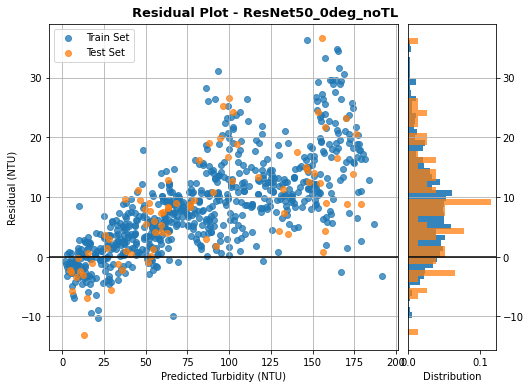

In [22]:
if not os.path.exists(f'plots/{name}'):
  os.makedirs(f'plots/{name}')

f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [4, 1]})

f.suptitle(f'Residual Plot - {name}', fontsize=13, fontweight='bold',  y=0.92) 
axs[0].scatter(pred,residuals, label='Validation Set', alpha=0.75, color='tab:green')   
axs[0].set_ylabel('Residual (NTU)')
axs[0].set_xlabel('Predicted Turbidity (NTU)')      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(residuals, bins=50, orientation="horizontal", density=True, alpha=0.9, color='tab:green')
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution')  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'plots/{name}/residualPlot_{name}.png', dpi=150)
plt.show()

Measured vs Predicted Plot

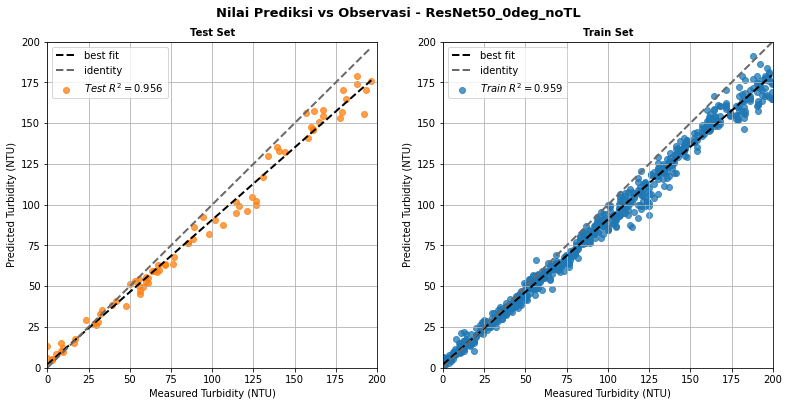

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=13, fontweight='bold',  y=0.96)

ax[0].scatter(true,pred, label=f'$Validation\ R^2=${round(score[3],3)}',color='tab:green', alpha=0.75)
theta = np.polyfit(true, pred, 1)
y_line = theta[1] + theta[0] * true
ax[0].plot([true.min(), true.max()], [y_line.min(), y_line.max()],'k--', lw=2,label='best fit')
ax[0].plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[0].set_xlabel('Measured Turbidity (NTU)')
ax[0].set_ylabel('Predicted Turbidity (NTU)')
ax[0].set_title(f'Validation Set', fontsize=10, fontweight='bold')
ax[0].set_xlim([0, 130])
ax[0].set_ylim([0, 130])
ax[0].grid()
ax[0].legend()

plt.savefig(f'plots/{name}/predErrorPlot_{name}.png', dpi=150)
plt.show()

In [ ]:
save_path = f"/content/gdrive/MyDrive/MODEL BERHASIL/Validation_Plots"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "plots/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive
print("Done!")

Done!
